# Project 3: Web APIs & NLP (Hyper Parameter Tuning and Modelling)

## Part 4: Hyperparameter Tuning and Modelling

### Import Libraries

In [1]:
#import libraries
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
import pickle

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve, plot_confusion_matrix, confusion_matrix

In [2]:
df = pd.read_pickle('datasets/combined.pkl')

In [3]:
#check if correctly imported
df.head()

,subreddit,title,selftext,all,all_tokens,clean_tokens,lem_tokens,title_length,selftext_length,title_word_count,selftext_word_count
0,iphone,iphone pro max wait for iphone,iphone pro max now better wait for the iph...,iphone pro max wait for iphone iphone pro max...,iphone pro max wait for iphone iphone pro max ...,iphone max wait iphone iphone max better wait ...,iphone max wait iphone iphone max better wait ...,31,271,6,44
1,iphone,switched from pixel iphone now can receive ...,there are some weird things going with messa...,switched from pixel iphone now can receive ...,switched from pixel iphone now can receive pho...,switched pixel iphone receive photos android u...,switched pixel iphone receive photo android us...,102,952,17,152
2,iphone,worth buying iphone pro max now better w...,hey there had iphone iphone and currently usi...,worth buying iphone pro max now better w...,worth buying iphone pro max now better wait fo...,worth buying iphone max better wait iphone rel...,worth buying iphone max better wait iphone rel...,72,266,12,42
3,iphone,iphone keeps going between normal and green,iphone recently got really wet storm and si...,iphone keeps going between normal and green i...,iphone keeps going between normal and green ip...,iphone keeps going normal green iphone recentl...,iphone keep going normal green iphone recently...,43,316,7,54
4,iphone,apple launching dsp advanced ads platform,one surprise the promises privacy tech gi...,apple launching dsp advanced ads platform ...,apple launching dsp advanced ads platform one ...,apple launching dsp advanced ads platform one ...,apple launching dsp advanced ad platform one s...,43,83,6,13


In [4]:
#remove general stopwords in the english language 
#remove additional words that are common for both subreddits
add_words = ['phone', 'mobile', 'handphone', 'pro', 'app', 'would', 'screen', 'like', 'get']
stop_words = stopwords.words('english') + add_words

### Baseline

In [5]:
df['subreddit'] = df['subreddit'].map({'iphone': 0, 'googlepixel': 1})
df.head()

,subreddit,title,selftext,all,all_tokens,clean_tokens,lem_tokens,title_length,selftext_length,title_word_count,selftext_word_count
0,0,iphone pro max wait for iphone,iphone pro max now better wait for the iph...,iphone pro max wait for iphone iphone pro max...,iphone pro max wait for iphone iphone pro max ...,iphone max wait iphone iphone max better wait ...,iphone max wait iphone iphone max better wait ...,31,271,6,44
1,0,switched from pixel iphone now can receive ...,there are some weird things going with messa...,switched from pixel iphone now can receive ...,switched from pixel iphone now can receive pho...,switched pixel iphone receive photos android u...,switched pixel iphone receive photo android us...,102,952,17,152
2,0,worth buying iphone pro max now better w...,hey there had iphone iphone and currently usi...,worth buying iphone pro max now better w...,worth buying iphone pro max now better wait fo...,worth buying iphone max better wait iphone rel...,worth buying iphone max better wait iphone rel...,72,266,12,42
3,0,iphone keeps going between normal and green,iphone recently got really wet storm and si...,iphone keeps going between normal and green i...,iphone keeps going between normal and green ip...,iphone keeps going normal green iphone recentl...,iphone keep going normal green iphone recently...,43,316,7,54
4,0,apple launching dsp advanced ads platform,one surprise the promises privacy tech gi...,apple launching dsp advanced ads platform ...,apple launching dsp advanced ads platform one ...,apple launching dsp advanced ads platform one ...,apple launching dsp advanced ad platform one s...,43,83,6,13


In [6]:
df.tail()

,subreddit,title,selftext,all,all_tokens,clean_tokens,lem_tokens,title_length,selftext_length,title_word_count,selftext_word_count
10999,1,pixel update animation bug anyone else experie...,prerequisites pixel animations config set fal...,pixel update animation bug anyone else experie...,pixel update animation bug anyone else experie...,pixel update animation bug anyone else experie...,pixel update animation bug anyone else experie...,67,336,9,45
11000,1,country code issue google contacts,having this issue with contacts all conta...,country code issue google contacts having t...,country code issue google contacts having this...,country code issue google contacts issue conta...,country code issue google contact issue contac...,35,475,5,75
11001,1,things that stand out about pixel pro,considering upgrading pixel pro from trust...,things that stand out about pixel pro conside...,things that stand out about pixel pro consider...,things stand pixel considering upgrading pixel...,thing stand pixel considering upgrading pixel ...,37,278,7,41
11002,1,custom rom recommendation pixel,have pixel looking for stable android rom...,custom rom recommendation pixel have pixel...,custom rom recommendation pixel have pixel loo...,custom rom recommendation pixel pixel looking ...,custom rom recommendation pixel pixel looking ...,32,140,4,21
11003,1,why can use hotspot without needing restart ...,don know when started but when turn hotspo...,why can use hotspot without needing restart ...,why can use hotspot without needing restart pi...,use hotspot without needing restart pixel know...,use hotspot without needing restart pixel know...,52,120,8,18


In [7]:
df.shape

(11004, 11)

In [8]:
X = df['lem_tokens']
y = df['subreddit']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7702,)
(7702,)
(3302,)
(3302,)


In [11]:
y.value_counts(normalize = True)

0    0.50727
1    0.49273
Name: subreddit, dtype: float64

### Multinomial Naive Bayes model

#### Multinomial Naive Bayes with Count Vectorizer

In [12]:
def get_metrics(modelname, model, X_train, X_test):
    print(modelname)
    print(u'\u2500' * 30)
    print(f"Accuracy score of training set: {round(100* model.score(X_train, y_train),2)}%")
    print(f"Accuracy score of testing set: {round(100* model.score(X_test, y_test),2)}%")
    print(u'\u2500' * 30)    
    return plot_confusion_matrix(model, X_test, y_test)

In [13]:
#instantiate CountVectorizer + MultinomialNB pipeline
pipe_nb_cvec = Pipeline([
    ('cvec', CountVectorizer(stop_words = stop_words)),
    ('nb', MultinomialNB())
])

# define pipeline parameters
pipe_nb_cvec_params = {
    'cvec__max_features': [2_000, 5_000, 10_000],
    'cvec__min_df': [2, 5, 8],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range': [(1,1), (1,2)]
}

# instantiate GridSearchCV
grid_nb_cvec = GridSearchCV(estimator=pipe_nb_cvec,
                      param_grid=pipe_nb_cvec_params,
                      cv=5, n_jobs=-1)

In [14]:
#fit GridSearchCV object to data
grid_nb_cvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
  

Multinomial Naive Bayes Model with Count Vectorizer
──────────────────────────────
Accuracy score of training set: 94.53%
Accuracy score of testing set: 92.7%
──────────────────────────────


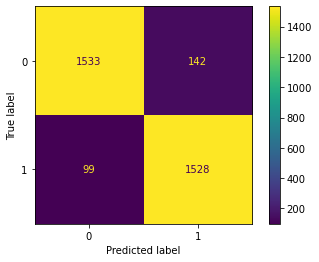

In [23]:
#print accuracy score for train and test set
#0 = r/phone, 1 = r/GooglePixel
get_metrics('Multinomial Naive Bayes Model with Count Vectorizer', grid_nb_cvec, X_train, X_test)

In [24]:
#get predictions
preds = grid_nb_cvec.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# Calculate accuracy, misclassification, specificity, sensitivity and precision
accuracy = (tp + tn) / (tp + tn + fp + fn)
misclassification = 1 - accuracy
spec = tn / (tn + fp)
sen = tp/(tp+fn)
precision = tp / (tp + fp)

print('Accuracy:', accuracy)
print('Misclassification:', misclassification)
print('Sensitivity:', sen)
print('Specificity:', spec)
print('Precision:', precision)
print('')
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

Accuracy: 0.9270139309509389
Misclassification: 0.07298606904906113
Sensitivity: 0.9391518131530424
Specificity: 0.9152238805970149
Precision: 0.9149700598802395

True Negatives: 1533
False Positives: 142
False Negatives: 99
True Positives: 1528


In [25]:
#print out best hyperparameters
grid_nb_cvec.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 8,
 'cvec__ngram_range': (1, 2)}

In [26]:
#transform X_train and X_test set for CountVectorizer with optimized hyperparameters
cvec = CountVectorizer(stop_words= stop_words,
                       max_features=5000,
                       max_df=0.9,
                       min_df=8,
                       ngram_range=(1,2))

X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

#### Multinomial Naive Bayes and TF-IDF Vectorizer

In [27]:
#instantiate TfidfVectorizer + MultinomialNB pipeline
pipe_nb_tvec = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = stop_words)),
    ('nb', MultinomialNB())
])

# define pipeline parameters
pipe_nb_tvec_params = {
    'tvec__max_features': [2_000, 5_000, 10_000],
    'tvec__min_df': [2, 5, 8],
    'tvec__max_df': [0.9, 0.95],
    'tvec__ngram_range': [(1,1), (1,2)]
}

# instantiate GridSearchCV
grid_nb_tvec = GridSearchCV(estimator=pipe_nb_tvec,
                      param_grid=pipe_nb_tvec_params,
                      cv=5, n_jobs=-1)

In [28]:
#fit GridSearchCV object to data
grid_nb_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
  

Multinomial Naive Bayes Model with TF-IDF Vectorizer
──────────────────────────────
Accuracy score of training set: 95.47%
Accuracy score of testing set: 91.1%
──────────────────────────────


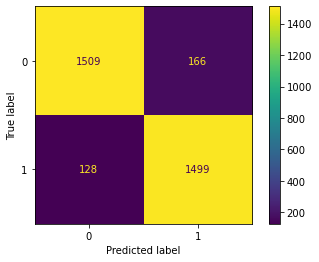

In [29]:
#print accuracy score for train and test set
#0 = r/phone, 1 = r/GooglePixel
get_metrics('Multinomial Naive Bayes Model with TF-IDF Vectorizer', grid_nb_tvec, X_train, X_test)

In [30]:
# Get predictions
preds_tvec = grid_nb_tvec.predict(X_test)

# Save confusion matrix values
tn2, fp2, fn2, tp2 = confusion_matrix(y_test, preds_tvec).ravel()

# Calculate accuracy, misclassification, specificity, sensitivity and precision
accuracy2 = (tp2 + tn2) / (tp2 + tn2 + fp2 + fn2)
misclassification2 = 1 - accuracy2
spec2 = tn2 / (tn2 + fp2)
sen2 = tp2/(tp2+fn2)
precision2 = tp2 / (tp2 + fp2)

print('Accuracy:', accuracy2)
print('Misclassification:', misclassification2)
print('Sensitivity:', sen2)
print('Specificity:', spec2)
print('Precision:', precision2)
print('')
print("True Negatives:", tn2)
print("False Positives:", fp2)
print("False Negatives:", fn2)
print("True Positives:", tp2)

Accuracy: 0.9109630526953362
Misclassification: 0.08903694730466383
Sensitivity: 0.9213275968039336
Specificity: 0.9008955223880597
Precision: 0.9003003003003003

True Negatives: 1509
False Positives: 166
False Negatives: 128
True Positives: 1499


In [31]:
# print out best parameters
grid_nb_tvec.best_params_

{'tvec__max_df': 0.9,
 'tvec__max_features': 10000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

In [32]:
#transform X_train and X_test set with TfidfVectorizer with optimized parameters
tvec = TfidfVectorizer(stop_words = stop_words,
                       max_features=10000,
                       max_df=0.9,
                       min_df=2,
                       ngram_range=(1,2))

X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

### Support Vector Machine

#### Support Vector Machines and CountVectorizer

In [33]:
# define GridSearchCV parameters
svc_params = {'C': [0.05, 0.1, 1, 10],
              'kernel': ['linear','poly','rbf'],
              'degree': [2,3]
}

# instantiate GridSearchCV
grid_svc_cvec = GridSearchCV(estimator=SVC(random_state=42, probability = True),
                             param_grid=svc_params,
                             cv=5, n_jobs=-1)

In [34]:
# fit GridSearchCV object to data
grid_svc_cvec.fit(X_train_cvec, y_train)

/Users/cherylleong/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [0.05, 0.1, 1, 10], 'degree': [2, 3],
                         'kernel': ['linear', 'poly', 'rbf']})

Support Vector Machine Model with CountVectorizer
──────────────────────────────
Accuracy score of training set: 98.36%
Accuracy score of testing set: 93.52%
──────────────────────────────


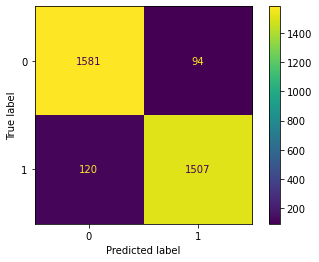

In [35]:
#print accuracy score for train and test set
#0 = r/phone, 1 = r/GooglePixel
get_metrics('Support Vector Machine Model with CountVectorizer', grid_svc_cvec, X_train_cvec, X_test_cvec)

In [36]:
# Get predictions
preds_svc_cvec = grid_svc_cvec.predict(X_test_cvec)

# Save confusion matrix values
tn3, fp3, fn3, tp3 = confusion_matrix(y_test, preds_svc_cvec).ravel()

# Calculate accuracy, misclassification, specificity, sensitivity and precision
accuracy3 = (tp3 + tn3) / (tp3 + tn3 + fp3 + fn3)
misclassification3 = 1 - accuracy3
spec3 = tn3 / (tn3 + fp3)
sen3 = tp3/(tp3+fn3)
precision3 = tp3 / (tp3 + fp3)

print('Accuracy:', accuracy3)
print('Misclassification:', misclassification3)
print('Sensitivity:', sen3)
print('Specificity:', spec3)
print('Precision:', precision3)
print('')
print("True Negatives:", tn3)
print("False Positives:", fp3)
print("False Negatives:", fn3)
print("True Positives:", tp3)

Accuracy: 0.93519079345851
Misclassification: 0.06480920654149003
Sensitivity: 0.9262446220036877
Specificity: 0.9438805970149253
Precision: 0.9412866958151156

True Negatives: 1581
False Positives: 94
False Negatives: 120
True Positives: 1507


In [37]:
# print out best parameters
grid_svc_cvec.best_params_

{'C': 0.05, 'degree': 2, 'kernel': 'linear'}

#### Support Vector Machines with TF-IDF Vectorizer

In [38]:
# instantiate GridSearchCV
grid_svc_tvec = GridSearchCV(estimator=SVC(random_state=42, probability = True),
                      param_grid=svc_params,
                      cv=5, n_jobs=-1)

In [39]:
# fit GridSearchCV object to data
grid_svc_tvec.fit(X_train_tvec, y_train)

GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [0.05, 0.1, 1, 10], 'degree': [2, 3],
                         'kernel': ['linear', 'poly', 'rbf']})

Support Vector Machine Model with TF-IDF Vectorizer
──────────────────────────────
Accuracy score of training set: 100.0%
Accuracy score of testing set: 94.37%
──────────────────────────────


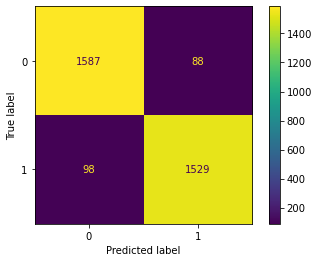

In [40]:
# print accuracy score for train and test set
#0 = r/phone, 1 = r/GooglePixel
get_metrics('Support Vector Machine Model with TF-IDF Vectorizer', grid_svc_tvec, X_train_tvec, X_test_tvec)

In [41]:
# Get predictions
preds_svc_tvec = grid_svc_tvec.predict(X_test_tvec)

# Save confusion matrix values
tn4, fp4, fn4, tp4 = confusion_matrix(y_test, preds_svc_tvec).ravel()

# Calculate accuracy, misclassification, specificity, sensitivity and precision
accuracy4 = (tp4 + tn4) / (tp4 + tn4 + fp4 + fn4)
misclassification4 = 1 - accuracy4
spec4 = tn4 / (tn4 + fp4)
sen4 = tp4/(tp4+fn4)
precision4 = tp4 / (tp4 + fp4)

print('Accuracy:', accuracy4)
print('Misclassification:', misclassification4)
print('Sensitivity:', sen4)
print('Specificity:', spec4)
print('Precision:', precision4)
print('')
print("True Negatives:", tn4)
print("False Positives:", fp4)
print("False Negatives:", fn4)
print("True Positives:", tp4)

Accuracy: 0.9436705027256208
Misclassification: 0.05632949727437919
Sensitivity: 0.9397664413030117
Specificity: 0.9474626865671641
Precision: 0.9455782312925171

True Negatives: 1587
False Positives: 88
False Negatives: 98
True Positives: 1529


In [42]:
# print out best parameters
grid_svc_tvec.best_params_

{'C': 10, 'degree': 2, 'kernel': 'rbf'}

### Random Forest Classifier

#### Random Forest and Count Vectorizer

In [43]:
# define GridSearchCV parameters
rf_params = {'n_estimators': [50, 100, 200, 400, 800, 1600],
             'max_depth': [None, 1, 2, 5, 10],
             'min_samples_split': [10, 20, 30],
             'min_samples_leaf':[5, 10, 15]
}

# instantiate GridSearchCV
grid_rf_cvec = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                      param_grid=rf_params,
                      cv=5, n_jobs=-1)

In [44]:
# fit GridSearchCV object to data
grid_rf_cvec.fit(X_train_cvec, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 1, 2, 5, 10],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [10, 20, 30],
                         'n_estimators': [50, 100, 200, 400, 800, 1600]})

In [45]:
# print out best parameters
grid_rf_cvec.best_params_

{'max_depth': None,
 'min_samples_leaf': 5,
 'min_samples_split': 20,
 'n_estimators': 800}

Random Forest Model with Count Vectorizer
──────────────────────────────
Accuracy score of training set: 96.18%
Accuracy score of testing set: 94.31%
──────────────────────────────


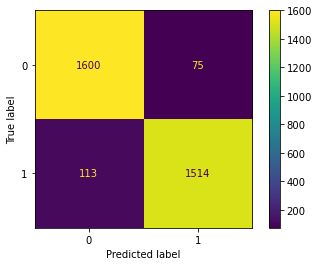

In [46]:
# print accuracy score for train and test set
#0 = r/phone, 1 = r/GooglePixel
get_metrics('Random Forest Model with Count Vectorizer', grid_rf_cvec, X_train_cvec, X_test_cvec)

In [47]:
preds_rf_cvec = grid_rf_cvec.predict(X_test_cvec)

# Save confusion matrix values
tn5, fp5, fn5, tp5 = confusion_matrix(y_test, preds_rf_cvec).ravel()

# Calculate accuracy, misclassification, specificity, sensitivity and precision
accuracy5 = (tp5 + tn5) / (tp5 + tn5 + fp5 + fn5)
misclassification5 = 1 - accuracy5
spec5 = tn5 / (tn5 + fp5)
sen5 = tp5/(tp5+fn5)
precision5 = tp5 / (tp5 + fp5)

print('Accuracy:', accuracy5)
print('Misclassification:', misclassification5)
print('Sensitivity:', sen5)
print('Specificity:', spec5)
print('Precision:', precision5)
print('')
print("True Negatives:", tn5)
print("False Positives:", fp5)
print("False Negatives:", fn5)
print("True Positives:", tp5)

Accuracy: 0.9430648092065415
Misclassification: 0.056935190793458545
Sensitivity: 0.9305470190534727
Specificity: 0.9552238805970149
Precision: 0.9528005034612964

True Negatives: 1600
False Positives: 75
False Negatives: 113
True Positives: 1514


#### Random Forest and TF-IDF Vectorizer

In [48]:
# instantiate GridSearchCV
grid_rf_tvec = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                      param_grid=rf_params,
                      cv=5, n_jobs=-1)

In [49]:
# fit GridSearchCV object to data
grid_rf_tvec.fit(X_train_tvec, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 1, 2, 5, 10],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [10, 20, 30],
                         'n_estimators': [50, 100, 200, 400, 800, 1600]})

In [50]:
# print out best parameters
grid_rf_tvec.best_params_

{'max_depth': None,
 'min_samples_leaf': 5,
 'min_samples_split': 30,
 'n_estimators': 800}

Random Forest Model with TF-IDF Vectorizer
──────────────────────────────
Accuracy score of training set: 97.07%
Accuracy score of testing set: 94.06%
──────────────────────────────


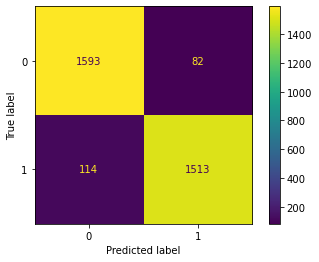

In [51]:
# print accuracy score for train and test set
#0 = r/phone, 1 = r/GooglePixel
get_metrics('Random Forest Model with TF-IDF Vectorizer', grid_rf_tvec, X_train_tvec, X_test_tvec)

In [52]:
preds_rf_tvec = grid_rf_tvec.predict(X_test_tvec)

# Save confusion matrix values
tn6, fp6, fn6, tp6 = confusion_matrix(y_test, preds_rf_tvec).ravel()

# Calculate accuracy, misclassification, specificity, sensitivity and precision
accuracy6 = (tp6 + tn6) / (tp6 + tn6 + fp6 + fn6)
misclassification6 = 1 - accuracy6
spec6 = tn6 / (tn6 + fp6)
sen6 = tp6/(tp6+fn6)
precision6 = tp6 / (tp6 + fp6)

print('Accuracy:', accuracy6)
print('Misclassification:', misclassification6)
print('Sensitivity:', sen6)
print('Specificity:', spec6)
print('Precision:', precision6)
print('')
print("True Negatives:", tn6)
print("False Positives:", fp6)
print("False Negatives:", fn6)
print("True Positives:", tp6)

Accuracy: 0.9406420351302242
Misclassification: 0.05935796486977585
Sensitivity: 0.9299323909035033
Specificity: 0.951044776119403
Precision: 0.94858934169279

True Negatives: 1593
False Positives: 82
False Negatives: 114
True Positives: 1513


### AUC/ROC

In [53]:
#print AUC Socre
p = grid_rf_tvec.predict_proba(X_test_tvec)
p2 = grid_rf_cvec.predict_proba(X_test_cvec)
p3 = grid_svc_tvec.predict_proba(X_test_tvec)
p4 = grid_svc_cvec.predict_proba(X_test_cvec)
p5 = grid_nb_tvec.predict_proba(X_test)
p6 = grid_nb_cvec.predict_proba(X_test)

p = p[:, 1]
p2 = p2[:, 1]
p3 = p3[:, 1]
p4 = p4[:, 1]
p5 = p5[:, 1]
p6 = p6[:, 1]

auc = round(roc_auc_score(y_test, p),2)
auc2 = round(roc_auc_score(y_test, p2),2)
auc3 = round(roc_auc_score(y_test, p3),2)
auc4 = round(roc_auc_score(y_test, p4),2)
auc5 = round(roc_auc_score(y_test, p5),2)
auc6 = round(roc_auc_score(y_test, p6),2)

print('Random Forest / tvec:', auc)
print('Random Forest / cvec:', auc2)
print('SVM / tvec:', auc3)
print('SVM / cvec:', auc4)
print('MNB / tvec:', auc5)
print('MNB / cvec:', auc6)

Random Forest / tvec: 0.99
Random Forest / cvec: 0.99
SVM / tvec: 0.99
SVM / cvec: 0.98
MNB / tvec: 0.97
MNB / cvec: 0.98


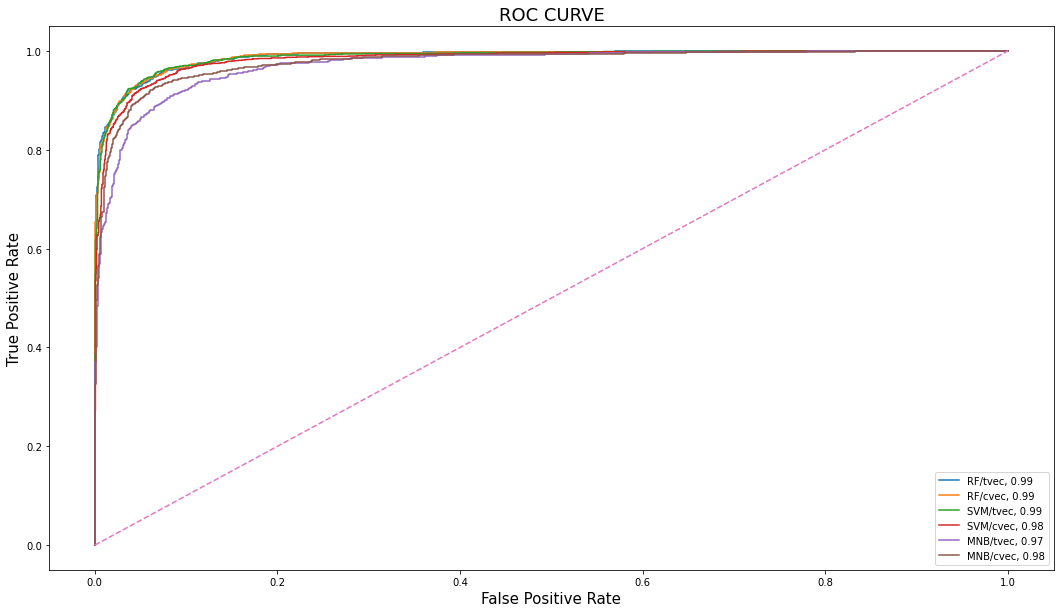

In [54]:
#print ROC Curve
plt.rcParams["figure.figsize"] = (18,10)

rf_tvec_roc = plot_roc_curve(grid_rf_tvec, X_test_tvec, y_test, label=f'RF/tvec, {auc}')
rf_cvec_roc = plot_roc_curve(grid_rf_cvec, X_test_cvec, y_test, ax = rf_tvec_roc.ax_, label=f'RF/cvec, {auc2}')
svc_tvec_roc = plot_roc_curve(grid_svc_tvec, X_test_tvec, y_test, ax = rf_tvec_roc.ax_, label=f'SVM/tvec, {auc3}')
svc_cvec_roc = plot_roc_curve(grid_svc_cvec, X_test_cvec, y_test, ax = rf_tvec_roc.ax_, label=f'SVM/cvec, {auc4}')
nb_tvec_roc = plot_roc_curve(grid_nb_tvec, X_test, y_test, ax = rf_tvec_roc.ax_, label=f'MNB/tvec, {auc5}')
nb_cvec_roc = plot_roc_curve(grid_nb_cvec, X_test, y_test, ax = rf_tvec_roc.ax_, label=f'MNB/cvec, {auc6}')
plt.plot([0, 1], [0, 1], label='baseline', linestyle='--') 

plt.title("ROC CURVE", fontsize = 18)
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)

plt.show();

### Findings

#### Misclassified Rows

In [57]:
miss_preds = grid_rf_cvec.predict(X_test_cvec)

In [58]:
miss_df = pd.DataFrame(data=X_test)
miss_df['actual'] = y_test
miss_df['predicted'] = miss_preds
final_miss_df = miss_df[miss_df['actual'] != miss_df['predicted']]

In [59]:
final_miss_df

,lem_tokens,actual,predicted
4929,looking crop device export original quality he...,0,1
9214,alarm sound changing set alarm detail text set...,1,0
6878,cracked help g dropped myag yesterday cracked ...,1,0
6532,love pixel except modem brief history summary ...,1,0
8704,vibrates new episode start chromecast wife alw...,1,0
...,...,...,...
775,disable mirrored mode front facing camera tryi...,0,1
8741,bihar ssc cgl exam going conducted soon bihar ...,1,0
9852,thought pixel low light video quality taken mu...,1,0
8732,chrome managed organization fresh usb install ...,1,0


In [60]:
final_miss_df['actual'].value_counts()

1    113
0     75
Name: actual, dtype: int64

Taking a look at the misclassified rows, the findings are as follows:
- both iphone/apple and pixel/google in their content
- have very little text in their content
- have generic text that is applicable to both subreddits

#### Results

|Estimator|Vectorizer|Train Accuracy|Test Accuracy|Generalization|Sensitivity|Specificity|AUC|
|---------|----------|--------------|-------------|--------------|-----------|-----------|---|
|Multinomial Naive Bayes|Count|94.53%|92.7%|1.83%|0.94|0.91|0.98|
|Multinomial Naive Bayes|Tfidf|95.47%|91.1%|4.37%|0.92|0.9|0.97|
|Support Vector Machine|Count|98.36%|93.52%|4.84%|0.93|0.94|0.98|
|Support Vector Machine|Tfidf|100%|94.37%|5.63%|0.94|0.95|0.99|
|Random Forest|Count|96.18%|94.31%|1.87%|0.93|0.96|0.99|
|Random Forest|Tfidf|97.07%|94.06%|3.01%|0.93|0.95|0.99|

- All of the models are overfitted
- Multinomial Naive Bayes with Count Vectorizer produced the best generalisation score, which is expected as NB model is usually high variance, low bias, and tend not to overfit data
- Support Vector Machine with Tfidf Vectorizer produced the highest accuracy but did not perform very well in terms of generalisation. Able to explore GridSearchCV with diffferent C values and probably introduce gamma to manipulate the curve
- Even though highest accuracy is the most important metric in this project, Random Forest with Count Vectorizer provides a relatively high accuracy (second) and good generalisation (second)
- Hence, I am inclined to choose Random Forest with Count Vectorizer as the preferred model

#### Improvements

We can try to improve on the overfitting seen in all the models and improve on the generalisation further by: 
- Increase amount of dataset used
- Try using different stop words
- Explore using Bagging Classifier
- Continue to use Random Forest but explore GridSearchCV more parameters in terms of n_estimator and max depth